In [1]:
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import glob
import datetime
import time
import sys
import os
import tables

pd.set_option('display.max_columns', None)

In [3]:
import keras
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

from sklearn.model_selection import cross_val_score, KFold, train_test_split, StratifiedKFold 
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, accuracy_score
from sklearn.preprocessing import StandardScaler

from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical,np_utils
from keras import backend
from keras.layers import Bidirectional, concatenate, SpatialDropout1D, GlobalMaxPooling1D

from keras.models import Model, Input, Sequential,model_from_json
from keras.layers import SimpleRNN, Embedding, Dense, GRU, LSTM, TimeDistributed, GRU, Lambda, \
                         Dropout, Bidirectional, Conv1D, Conv2D, BatchNormalization, Flatten, Activation
from keras.optimizers import SGD, Adam, RMSprop
from keras.optimizers import *
from keras.regularizers import l2
from keras.wrappers.scikit_learn import KerasClassifier

from keras.layers.convolutional import MaxPooling1D, MaxPooling2D
print(keras.__version__)
print(tf.__version__)

Using TensorFlow backend.


2.2.4
1.13.0-rc2


# Overview

This notebook extracts the numerical information in arrays (i.e. segment pitch, loudness, timbre) and explored whether it has any predictive power for song hotness. I have looked at the numerical arrays on their own (without using any song metadata or other data) in order to assess whether they should be included in the model or not. 

The conclusions of this analysis are that the raw data in arrays does not seem to be predictive. However, the lessons learned from designing the network architecture in a way that can ingest the time series of track features could be applied to other features.  

# Load all of the subset data

This loads the subset_full.pkl obtained by running the EDA notebook.

In [4]:
# Check current working directory
cur_dir = os.getcwd()
print("current dir:", cur_dir)

current dir: /Users/gena/Documents/GitHub/CS109B_MSD/notebooks/EDA


In [5]:
# Path to the Million Song Dataset subset (uncompressed) - change to the location on your laptop
# Cannot store this on github as it is too large
msd_subset_path = '../../../MSD_data/MillionSongSubset/'

# Keep these - folders match the structure of the uncompressed file
msd_subset_data_path = os.path.join(msd_subset_path, 'data')
msd_subset_addf_path = os.path.join(msd_subset_path, 'AdditionalFiles')

In [6]:
# Load previously saved file (see EDA notebook)
subset_full = pd.read_pickle(msd_subset_path+'subset_full.pkl')

In [7]:
# Select only the data with song_hotness
data = subset_full.dropna(subset = ['song_hotttnesss']).reset_index()

As previously noted in the EDA, the segment data has the most detailed information out of all of the arrays - containing not only start times and confidence, but also loudness, pitches and timbre. Therefore, it is this information that is explored further

In [8]:
# Identify the columns that have arrays
segment_array_list = [
                        'segments_confidence',
                        'segments_loudness_max',
                        'segments_loudness_max_time',
                        'segments_loudness_start',
                        'segments_pitches',
                        'segments_start',
                        'segments_timbre',

                       ]

# Create lookups
lookups = dict(enumerate(segment_array_list))


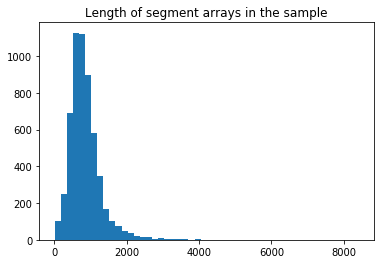

In [9]:
# Check distribution of lengths
lengths = [len(i) for i in data['segments_confidence']]
plt.hist(lengths, bins = 50)
plt.title('Length of segment arrays in the sample');

# Creation of cropped arrays for segment data

This version of the data contains a 26 dimensional vector for each included segment, consisting of concantenated data in the following order:
* loudness at start of segment 
* maximum loudness in each segment
* 12 timbre features 
* 12 chroma features

For eaasier analysis, I have created fixed-length arrays by taking the first 350 segments and excluding tracks that don't have at least this number of segments. This should be sufficient to capture the main parts of each song.

Each of the inputs has been scaled using min max scaling.

In [10]:
# There are 5648 songs with hotness data
len(data)

5648

In [11]:
# Function to create the arrays
def create_arrays(max_len = 100):
    ''' Creates array data for tracks that have at least max_len segments '''
    segment_data = []
    y = []
    for i in range(0, len(data)):
        
        # Check if array has at least max_len elements - skip if not
        if len(data['segments_loudness_start'][i]) < max_len:
            pass
        else:
            # Get the segment arrays
            loudness = data['segments_loudness_start'][i][:max_len].reshape(-1, 1)
            max_loudness = data['segments_loudness_max'][i][:max_len].reshape(-1, 1)
            timbre = data['segments_timbre'][i][:max_len]
            pitches = data['segments_pitches'][i][:max_len]
            
            # Concatenate to make a max_len x 25 array
            temp = np.concatenate((loudness, max_loudness, timbre, pitches), axis = 1)
            segment_data.append(temp)
            
            # Get the target variable
            y.append(data['song_hotttnesss'][i])
            
    print('{} tracks converted'.format(len(y)))
    return pd.Series(y), np.array(segment_data)            
            

Choosing a longer length to include means that we drop more tracks since not all of them have sufficient length.

In [12]:
# Create data
y, segment_data = create_arrays(max_len = 350)

5289 tracks converted


In [13]:
# Shape is [samples, timesteps, features]
segment_data.shape

(5289, 350, 26)

# Create training and test sets

This part creates training and test sets for both regression and classification tasks. 

It is turned into a classification problem by setting the songs with the highests 25% of hotnesss values to be hot, and the rest not. 

In [14]:
# Train and test split
x_train, x_test, y_train, y_test = train_test_split(segment_data, y, test_size = 0.1, random_state = 42)
x_train.shape, y_train.shape

((4760, 350, 26), (4760,))

In [15]:
# Scale the data
print('Min and max before: ({}, {})'.format(x_train.min(), x_train.max()))
x_min = x_train.min(keepdims = True)
x_max = x_train.max(keepdims = True)

x_train = (x_train - x_min)/(x_max - x_min)
x_test = (x_test - x_min)/(x_max - x_min)

print('Min and max after scaling: ({}, {})'.format(x_train.min(), x_train.max()))

Min and max before: (-497.745, 508.462)
Min and max after scaling: (0.0, 1.0)


In [16]:
# Simplify by only setting top 25% of song_hotness to be "hot" and the rest "not"

def convert_y_to_categorical(cutoff = 0.75):
    threshold = y.quantile(cutoff)
    Y = [0 if i < threshold else 1 for i in y]
    return np.array(Y)
Y = convert_y_to_categorical()

# y values for classification
Y_cat_train, Y_cat_test = train_test_split(Y, test_size = 0.1, random_state = 42)

# y values for regression
Y_reg_train, Y_reg_test = y_train, y_test

# Model architectures

The code below is flexible to perform classification (set classification = True) or regression. 

## CRNN

The model architecture below is a CRNN network. It first passes the data through a seriess of convolutions before feeding to a Gated Reucurrent Unit (GRU). Given the imbalance in the training data, the classes are balanced in the model fitting.

* I have used __1D convolution layers__ that perform convolution operations just across the time dimension. This is to extract features from each time slice (rather than 2D convolution more frequently seen in image processing).  Dropout and max pooling are used to prevent overfitting. 
* The output of the CNN step is fed into a __GRU, which should find the short and long term structure of the audio features__. Recurrent neural networks (RNN) are used for understanding sequential data. They make a hidden state t dependent on the hidden state in the previous time step. 



In [17]:
# C-RNN
def build_train_CRNN(x_train, y_train, 
                      n_layers, n_conv_filters, filter_size,
                      n_RNN, n_hidden, 
                      drop_rate = 0.2,
                      activation = 'relu',
                      optimizer = 'adam',
                      loss = 'binary_crossentropy',
                      metrics = ['accuracy'],
                      num_classes = 1, # For simplified classification model
                      n_features = x_train.shape[2],
                      n_time = x_train.shape[1],
                      batch_size = 32,
                      epochs = 10,
                      validation_split = 0.1,
                      verbose = 1,
                      print_summary = False,
                     classification = True):
    '''
    Builds and trains a CNN-RNN model. Prints model performance graphs and metrics
    
    Params:
        x_train, y_train = training data - choose Y_reg_train/test or Y_cat_train/test for classification and regression respectively
        n_layers = number of convolution layers
        n_conv_filters = number of filters in each conv layer
        filter_size = size of conv filters
        n_RNN = number of units in the GRU
        n_hidden = number of units in the dense layer
        drop_rate = dropout rate
    Returns:
        Model and model history
    '''
    
    print('Building model...')
    input_shape = (None, n_features)
    model_input = Input(input_shape, name = 'input')
    layer = model_input
    
    # 1D convolutions
    for i in range(n_layers):
        layer = Conv1D(
                filters = n_conv_filters,
                kernel_size = filter_size,
                name = 'convolution_' + str(i + 1)
            )(layer)
        layer = BatchNormalization(momentum = 0.9)(layer)
        layer = Activation(activation)(layer)
        layer = MaxPooling1D(2)(layer)
        layer = Dropout(drop_rate)(layer)
    
    # GRU Layer
    layer = GRU(n_RNN, return_sequences = False)(layer)
    layer = Dropout(drop_rate)(layer)
    
    # Dense Layer
    layer = Dense(n_hidden, name = 'dense1')(layer)
    layer = Dropout(drop_rate)(layer)
    
    # Output
    if classification:
        layer = Dense(num_classes)(layer)
        layer = Activation('sigmoid')(layer)
    else:
        layer = Dense(1)(layer)
    model_output = layer
    model = Model(model_input, model_output)
    
    # Compile
    model.compile(
            loss = loss,
            optimizer = optimizer,
            metrics = metrics
        )
    if print_summary:
        print(model.summary())
    
    # Fit
    print('Training model...')
    history = model.fit(x_train, y_train, 
                    epochs = epochs,
                    batch_size = batch_size,
                   validation_split = validation_split,
                   verbose = verbose,
                       class_weight = 'balanced')
    # Plot the accuracy / loss depending on classification or regression
    if classification:
        plot_summary(history)
        
        # Get test set confusion matrix for the classification model
        y_pred = model.predict(x_test).argmax(axis = 1)
        print('Confusion matrix:')
        print(confusion_matrix(y_pred, y_test))
        print('Model test accuracy: {}'.format(accuracy_score(y_pred, y_test)))
    else:
        plot_summary(history, metric = 'loss')
        
        # Get test MSE for regression model
        y_pred = model.predict(x_test)
        print('Model test MSE: {}'.format(mean_squared_error(y_pred, y_test)))
    
    return model, history


def plot_summary(history, metric = 'acc'):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric])
    plt.title('Model performance')
    plt.ylabel(metric)
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc = 'upper left')
    plt.show()

## Parallel CNN-RNN 

The CRNN model above uses RNNs as a temporal summariser, but the GRU uses the output of the CNNs. 

In a parallel CNN-RNN model, the artchitecture has the following structure:
* The signals are passed through 2D convolutions followed by max pooling and the final output is flattened. This is similar to image processing where the signals are now processed in 2D. 
* Separately, the signals are passed through RNN
* The outputs of both steps are concatenated and passed to a dense network. 

This approach allows us to preserve the temporal relationships of the original signals and use CNN and RNN in parallel.

In [18]:
# Parallel CNN RNN
def build_train_parallel(x_train, y_train, 
                      n_layers, n_conv_filters, filter_size,
                      n_RNN, n_hidden, 
                      drop_rate = 0.2,
                      activation = 'relu',
                      optimizer = 'adam',
                      num_classes = 1, # For simplified model
                      n_features = x_train.shape[2],
                      n_time = x_train.shape[1],
                      batch_size = 32,
                      epochs = 10,
                      validation_split = 0.1,
                      verbose = 1,
                      print_summary = False,
                     classification = True):
    '''
    Builds and trains a parallel CNN/RNN model. Prints model performance graphs and metrics
    
    Params:
        x_train, y_train = training data - choose Y_reg_train/test or Y_cat_train/test for classification and regression respectively
        n_layers = number of convolution layers
        n_conv_filters = number of filters in each conv layer
        filter_size = size of conv filters
        n_RNN = number of units in the GRU
        n_hidden = number of units in the dense layer
        drop_rate = dropout rate
    Returns:
        Model and model history
    '''
    
    print('Building model...')
    
    # Inputs for Conv2D need to be reshaped
    x_train = np.expand_dims(x_train, axis = -1)
    
    input_shape = (n_time, n_features, 1)
    model_input = Input(input_shape, name = 'input')
    layer = model_input
    
    # 2D convolutions
    for i in range(n_layers):
        layer = Conv2D(
                filters = n_conv_filters,
                kernel_size = filter_size,
                strides = 1, padding = 'same',
                name = 'convolution_' + str(i + 1)
            )(layer)
        layer = BatchNormalization(momentum = 0.9)(layer)
        layer = Activation(activation)(layer)
        layer = MaxPooling2D((2, 2))(layer)
        layer = Dropout(drop_rate)(layer)
        
    flatten1 = Flatten()(layer)
    
    # GRU Layer
    squeezed = Lambda(lambda x: K.squeeze(x, axis= -1))(model_input)
    GRU_block = GRU(n_RNN, return_sequences = False)(squeezed)
    GRU_block = Dropout(drop_rate)(GRU_block)
    
    # Concatenate
    concat = concatenate([flatten1, GRU_block], axis = -1, name = 'concat')
    
    # Dense layer
    concat = Dense(n_hidden)(concat)
    
    # Output
    if classification:
        concat = Dense(num_classes)(concat)
        concat = Activation('sigmoid', name = 'output')(concat)
    else:
        concat = Dense(1)(concat)
    model_output = concat
    model = Model(model_input, model_output)
    
    # Compile
    if classification:
        model.compile(
                loss = 'binary_crossentropy',
                optimizer = optimizer,
                metrics = ['accuracy']
            )
    else:
        model.compile(
                loss = 'mean_squared_error',
                optimizer = optimizer,
                metrics = []
            )        
    if print_summary:
        print(model.summary())
    
    # Fit
    print('Training model...')
    history = model.fit(x_train, y_train, 
                    epochs = epochs,
                    batch_size = batch_size,
                   validation_split = validation_split,
                   verbose = verbose,
                       class_weight = 'balanced')
    # Plot the accuracy / loss depending on classification or regression
    if classification:
        plot_summary(history)
        
        # Get test set confusion matrix for the classification model
        y_pred = model.predict(np.expand_dims(x_test, axis = -1)).argmax(axis = 1)
        print('Confusion matrix:')
        print(confusion_matrix(y_pred, y_test))
        print('Model test accuracy: {}'.format(accuracy_score(y_pred, y_test)))
    else:
        plot_summary(history, metric = 'loss')
        
        # Get test MSE for regression model
        y_pred = model.predict(np.expand_dims(x_test, axis = -1))
        print('Model test MSE: {}'.format(mean_squared_error(y_pred, y_test)))
    
    return model, history


# Classification model

As noted earlier, the y variable is changed to a classification task by labelling all songs in the top 25% of hotness as "hot" and the rest as "not hot". 

In [29]:
# Set y to classification variables
y_train, y_test = Y_cat_train, Y_cat_test

Building model...
Training model...


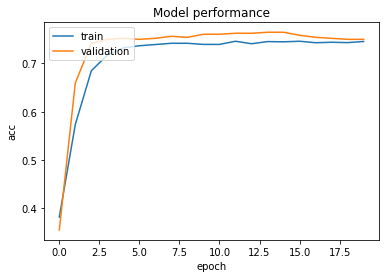

Confusion matrix:
[[400 129]
 [  0   0]]
Model test accuracy: 0.7561436672967864


In [20]:
# Run the CRNN classification model
model_params = dict(classification = True,
                      n_layers = 3, # Number of convolution layers
                      n_conv_filters = 64, # Number of filters in each conv
                      filter_size = 3, # Size of conv filters
                      n_RNN = 64, # GRU units
                      n_hidden = 128, # Number of units in the dense layer
                      drop_rate = 0.3, # Dropout rate
                      activation = 'relu',
                      optimizer = Adam(lr = 0.00001),
                      batch_size = 32,
                      epochs = 20,
                      verbose = 0)

model, history = build_train_CRNN(x_train, y_train, **model_params)

This classification model is pretty useless - it is just predicting all songs are not hot. This may because the process of creating the hot or not tags was not appropriate. We will have to try another approach.

Building model...
Training model...


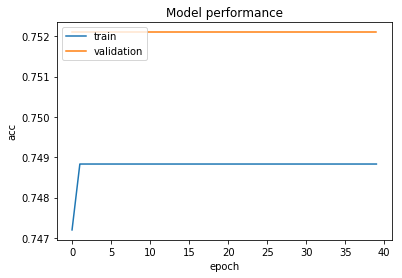

Confusion matrix:
[[400 129]
 [  0   0]]
Model test accuracy: 0.7561436672967864


In [30]:
# Try the parallel CNN/RNN model with the same parameters as the CRNN model
# This takes ages to run on CPU
model_params.update(dict(classification = True, 
                         epochs = 40,
                        optimizer = 'adam')) # Some compatability problems with adam - maybe due to tf version
backend.clear_session()
model, history = build_train_parallel(x_train, y_train, **model_params)

**Conclusions:**

This approach to classification has been unsuccessful. We will try the same models and data below, but this time using a regression approach. 

# Regression model

Given the finding above that the classification model is not performing any useful analysis, this section returns to a regression model. It uses the same network architecture and train/test split as before. 

In [22]:
# Set y variables to the regression data
y_train, y_test = Y_reg_train, Y_reg_test

In [23]:
# Baseline regression performance
y_bar = np.mean(y_train)
baseline_mse = mean_squared_error(np.repeat(y_bar, len(y_train)), y_train)
print('Baseline MSE: {}'.format(baseline_mse))

Baseline MSE: 0.06124312000239842


Building model...
Training model...


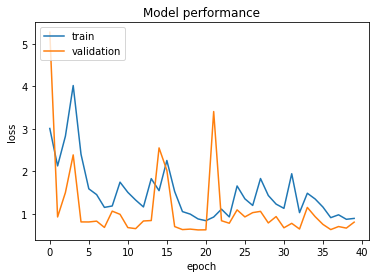

Model test MSE: 0.06855475599420417


In [24]:
# Use the same parameters as before, but change to regression
backend.clear_session()
model_params.update(dict(classification = False))

model, history = build_train_CRNN(x_train, y_train, **model_params)

Building model...
Training model...


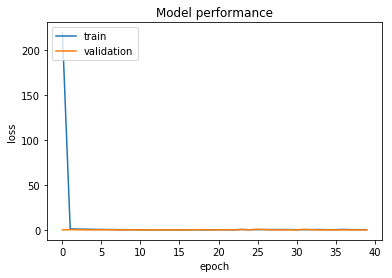

Model test MSE: 0.059241948140060494


In [25]:
# And again with the parallel model
backend.clear_session()
model_params.update(dict(classification = False))
model, history = build_train_parallel(x_train, y_train, **model_params)

# Conclusions

We have not been able to find any predictive power in using the segment array data from the MSD to predict song hotness. We tried both classification and regression models, but they did not perform well. We tried to design the networks to take advantage of the time series in two ways:

1. Using CRNN model. This is where 1D convolutions are performed on the segment data in order to capture features from each time slice. The output of the CNN step is fed into a GRU, which should find the short and long term structure of the audio features. 
2. Using parallel CNN and RNN model. 
    * The signals are passed through 2D convolutions followed by max pooling and the final output is flattened. This is similar to image processing where the signals are now processed in 2D.
    * Separately, the signals are passed through RNN.
    * The outputs of both steps are concatenated for prediction.

Therefore it seems that these variables can be dropped from further analysis.

However, the lessons learned in designing the model architecture and applying it to the time series of track audio features may be useful and can be applied to some of the other features we have been investigating. 